In [1]:
%load_ext lab_black
%load_ext autotime
import pandas as pd
import numpy as np

time: 277 ms (started: 2022-12-23 16:40:12 -08:00)


[Galaxy10 SDSS](https://astronn.readthedocs.io/en/latest/galaxy10sdss.html) contains nearly 22,000 69x69 color images of galaxies from the [Sloan Digital Sky Survey](http://www.sdss.org/). They were classified into 10 groups via crowd-sourcing on [Galaxy Zoo](https://www.galaxyzoo.org/). This dataset was originally called just "Galaxy 10" but has been superceded by the [Galaxy10 DECals](https://astronn.readthedocs.io/en/latest/galaxy10.html) dataset.

## Read the file

When I tried to access this file, I got an SSL certificate error. As a result, the call to `requests.get` below uses the `verify=False`. This is the source of the warnings below.

In [2]:
from io import BytesIO

import h5py
import numpy as np
import requests

url = "http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5"
req = requests.get(url, allow_redirects=True, verify=False, timeout=10)

with h5py.File(BytesIO(req.content), "r") as file:
    images = np.array(file["images"])
    labels = np.array(file["ans"])

/home/james/dev/drnb/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'astro.utoronto.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/home/james/dev/drnb/venv/lib/python3.10/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.astro.utoronto.ca'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


time: 11.4 s (started: 2022-12-23 16:40:13 -08:00)


In [3]:
images.shape

(21785, 69, 69, 3)

time: 8.66 ms (started: 2022-12-23 16:40:25 -08:00)


In [4]:
labels

array([2, 2, 4, ..., 2, 9, 2], dtype=uint8)

time: 5.33 ms (started: 2022-12-23 16:40:28 -08:00)


The 10 classes are imbalanced:

In [5]:
import collections

sorted(collections.Counter(labels).items())

[(0, 3461),
 (1, 6997),
 (2, 6292),
 (3, 349),
 (4, 1534),
 (5, 17),
 (6, 589),
 (7, 1121),
 (8, 906),
 (9, 519)]

time: 9.72 ms (started: 2022-12-23 16:40:29 -08:00)


As you can see, there are only 17 examples of class 5 (which is the "Disk, Edge-on, Boxy Bulge" class).

## View a galaxy image

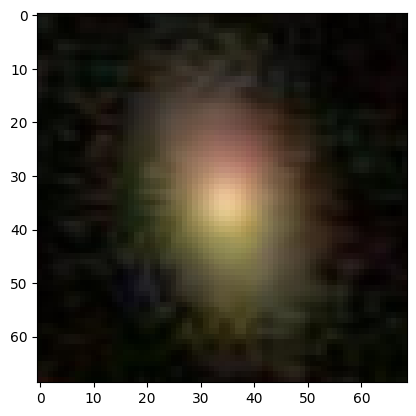

time: 954 ms (started: 2022-12-23 16:40:33 -08:00)


In [6]:
import matplotlib.pyplot as plt

plt.imshow(
    images[0],
    interpolation="nearest",
    vmin=0,
    vmax=255,
)

## Pipeline

In [7]:
data = images.reshape(
    (images.shape[0], images.shape[1] * images.shape[2] * images.shape[3])
)

time: 3.36 ms (started: 2022-12-23 16:40:36 -08:00)


In [8]:
data.shape

(21785, 14283)

time: 3.84 ms (started: 2022-12-23 16:40:39 -08:00)


The class names can be found at <https://github.com/henrysky/astroNN/blob/9cd32944285634ba26f83fb414ea766693627004/docs/source/galaxy10sdss.rst>.

In [9]:
class_names = [
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral",
]

time: 2.95 ms (started: 2022-12-23 16:40:41 -08:00)


In [10]:
from drnb.util import categorize, codes_to_categories

target = pd.DataFrame(
    dict(
        Label=labels, Class_Name=codes_to_categories(labels, class_names, "Class_Name")
    )
)
categorize(target, "Label")
target

,Label,Class_Name
0,2,"Smooth, in-between round"
1,2,"Smooth, in-between round"
2,4,"Disk, Edge-on, Rounded Bulge"
3,2,"Smooth, in-between round"
4,4,"Disk, Edge-on, Rounded Bulge"
...,...,...
21780,2,"Smooth, in-between round"
21781,1,"Smooth, Completely round"
21782,2,"Smooth, in-between round"
21783,9,"Disk, Face-on, Loose Spiral"


time: 30.9 ms (started: 2022-12-23 16:40:43 -08:00)


In [12]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(check_for_duplicates=True).run(
    "galaxy10sdss",
    data=data,
    target=target,
    tags=["image", "vhighdim"],
    url="https://astronn.readthedocs.io/en/latest/galaxy10sdss.html",
    verbose=True,
)

[16:41:01] INFO     Requesting one extra neighbor to account for self-neighbor                      ]8;id=27860;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=280241;file:///home/james/dev/drnb/src/drnb/neighbors/__init__.py#493\493]8;;\

           INFO     Initial data shape: (21785, 14283)                                               ]8;id=121880;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=970173;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#75\75]8;;\

           INFO     Keeping all columns                                                            ]8;id=447302;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=376769;file:///home/james/dev/drnb/src/drnb/preprocess.py#67\67]8;;\

           INFO     Data shape after filtering columns: (21785, 14283)                              ]8;id=626001;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=674770;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#146\146]8;;\

           INFO     Removing rows with NAs                                                          ]8;id=610463;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=197252;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#130\130]8;;\

           INFO     Data shape after filtering NAs: (21785, 14283)                                  ]8;id=571168;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=802575;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#141\141]8;;\

[16:41:05] INFO     Checked for duplicates: found 0                                                 ]8;id=143412;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=225372;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#153\153]8;;\

           INFO     No scaling                                                                     ]8;id=586967;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=437;file:///home/james/dev/drnb/src/drnb/preprocess.py#25\25]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}                    ]8;id=47938;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=590625;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#158\158]8;;\

           INFO     Writing data for galaxy10sdss                                                   ]8;id=13760;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=190220;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#222\222]8;;\

[16:46:10] INFO     Processing target with initial shape (21785, 2)                                 ]8;id=506695;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=884243;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#193\193]8;;\

           INFO     Keeping all columns                                                            ]8;id=556531;file:///home/james/dev/drnb/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=35409;file:///home/james/dev/drnb/src/drnb/preprocess.py#67\67]8;;\

           INFO     Writing target for galaxy10sdss                                                 ]8;id=815137;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=923554;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#222\222]8;;\

           INFO     Calculating nearest neighbors                                                   ]8;id=728475;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=11806;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#237\237]8;;\

           INFO     Loading faiss with AVX2 support.                                                   ]8;id=513358;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=725440;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=564660;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=511558;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=51675;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=315188;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=52746;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=661396;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[16:47:43] INFO     Calculating triplets                                                            ]8;id=307853;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=329432;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#248\248]8;;\

[16:47:45] INFO     Writing csv format to triplets/galaxy10sdss.5.1337.idx.csv                      ]8;id=977578;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=60798;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

[16:47:46] INFO     Writing csv format to triplets/galaxy10sdss.5.1337.euclidean.csv                ]8;id=68008;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=174521;file:///home/james/dev/drnb/src/drnb/io/__init__.py#224\224]8;;\

           INFO     Writing numpy format to triplets/galaxy10sdss.5.1337.idx.npy                    ]8;id=636041;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=398111;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

[16:47:47] INFO     Writing numpy format to triplets/galaxy10sdss.5.1337.euclidean.npy              ]8;id=48158;file:///home/james/dev/drnb/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=306194;file:///home/james/dev/drnb/src/drnb/io/__init__.py#247\247]8;;\

           INFO     Writing pipeline result for galaxy10sdss                                        ]8;id=732310;file:///home/james/dev/drnb/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=302815;file:///home/james/dev/drnb/src/drnb/io/pipeline.py#123\123]8;;\

time: 6min 45s (started: 2022-12-23 16:41:01 -08:00)


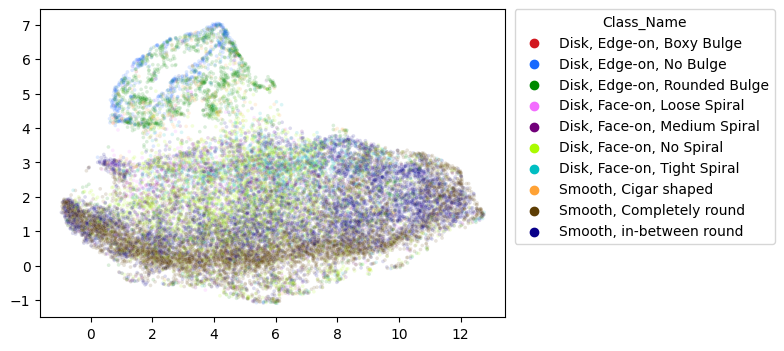

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.7838145512967637, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.6910011935565762, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.09409838573942315, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.13790222630250173, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.19141733608752198, info={'metric': 'euclidean', 'n_neighbors': 150})]

time: 32.3 s (started: 2022-12-23 16:48:24 -08:00)


In [14]:
import drnb.embed.pipeline as pl

pl.standard_eval(method="umap", dataset="galaxy10sdss")